# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [39]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import random
from skimage.transform import ProjectiveTransform, warp

# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [67]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # (idx1, idx2, distance)
    matches = []
    for idx1 in range(len(kp1)):
        idx2 = np.argmin(dist[idx1])
        matches.append([kp1[idx1].pt[0], kp1[idx1].pt[1], kp2[idx2].pt[0], kp2[idx2].pt[1], dist[idx1][idx2]])

    matches = np.array(sorted(matches, key = lambda x: x[4])[:num_matches])
    matches = matches[:, :4]
    
    return matches

def ransac(matches, iteration_times = 100, threshold = 4.0):
    """
    write your ransac code to find the best model, inliers, and residuals
    """

    best_model = None
    best_inliners = []
    best_residual = 0

    for i in range(iteration_times):
        indices = np.random.randint(0, len(matches), 4)
        sample_points = matches[indices]

        # get A for AX = 0
        A = []
        for (x1, y1, x2, y2) in sample_points:
            A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
            A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2])
        
        A = np.array(A)
        H = compute_homography(A)

        # for each point, use H to transform (x1, y1) to (x2, y2). Then, calculate the distance as residual
        inliners = []
        residual = 0
        for (x1, y1, x2, y2) in matches:
            point1 = np.array([x1, y1, 1])
            trans_point1 = np.dot(H, point1)
            trans_point1 /= trans_point1[2] # (x / z, y / z, 1)

            point2 = np.array([x2, y2])
            dist = np.linalg.norm(trans_point1[:2] - point2)
            if dist < threshold:
                inliners.append((x1, y1, x2, y2))
                residual += dist ** 2
        
        # update the best model
        if len(inliners) > len(best_inliners):
            best_model = H
            best_inliners = inliners
            best_residual = residual

    avg_residual = best_residual / len(best_inliners)
    
    return best_model, np.array(best_inliners), avg_residual

def compute_homography(A):
    _, _, Vt  = np.linalg.svd(A)
    H = Vt[-1, :]
    H = H.reshape((3, 3))

    return H


def warp_images(img1, img2, H):
    img1 = img1.astype(np.float32) / 255
    img2 = img2.astype(np.float32) / 255
    

    warped_img2 = warp(img2, ProjectiveTransform(H), output_shape=(img1.shape[0], img1.shape[1] + img2.shape[1]))
    panorama = np.zeros((img1.shape[0], img1.shape[1] + img2.shape[1], 3), dtype=np.float32)
    panorama[:, :img1.shape[1]] = img1

    # add image 2 on panorama
    for i in range(warped_img2.shape[0]):
        for j in range(warped_img2.shape[1]):
            if j < img1.shape[1] and np.any(panorama[i, j] != 0):
                continue
            else:
                panorama[i, j] = warped_img2[i, j]

    panorama = (panorama * 255).astype(np.uint8)

    return panorama
    

# Main functions

#### Load images

In [68]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

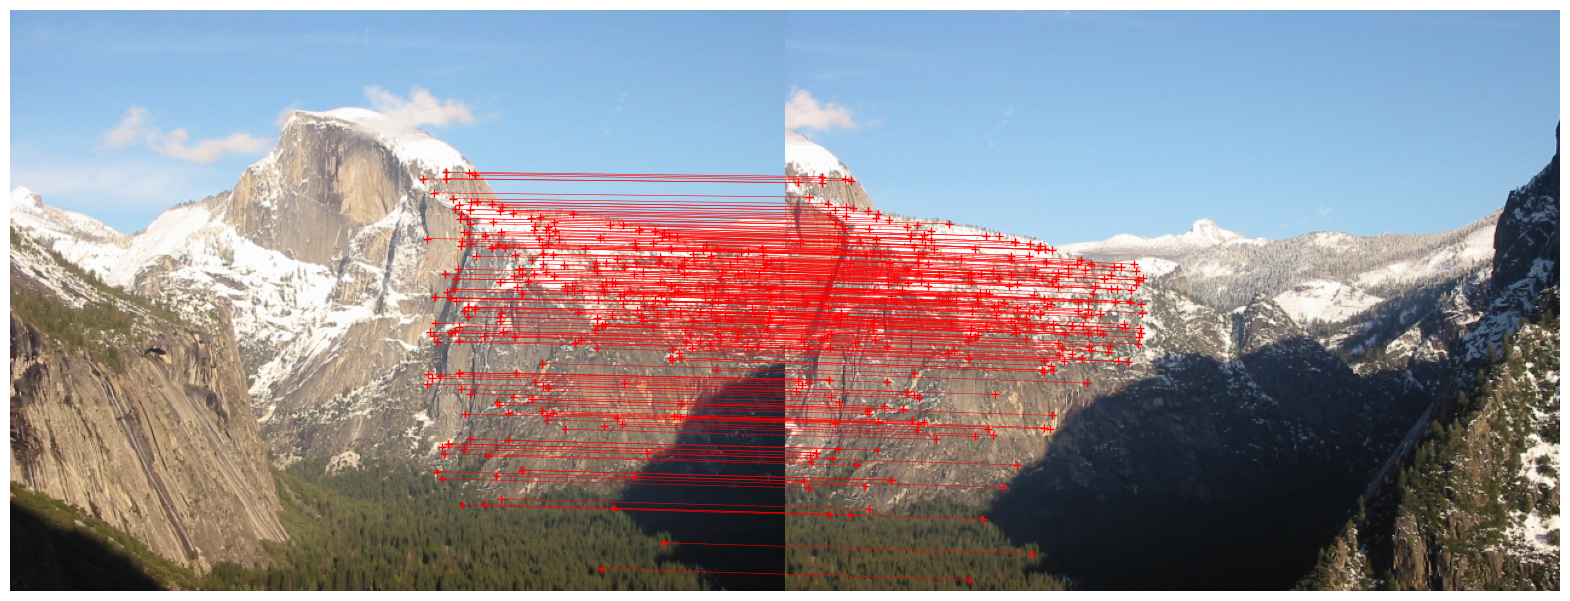

In [69]:
data = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

Average residual: 0.0234
146


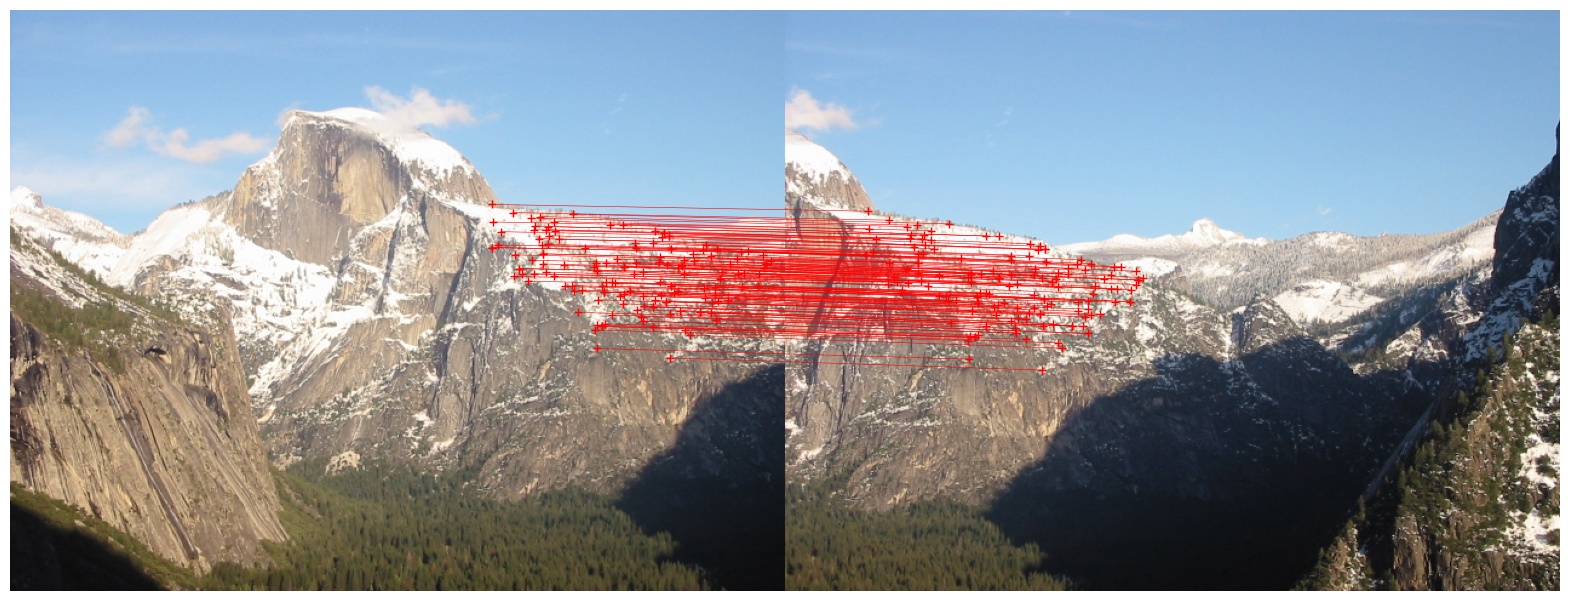

In [92]:
# display the inlier matching, report the average residual
best_model, max_inliers, best_model_errors = ransac(data, iteration_times = 10, threshold = 0.3)
# print(best_model)
print("Average residual:", f"{np.average(best_model_errors):.4f}")
print(f"{len(max_inliers)}")
# print("Inliers:", max_inliers)

# TODO:
# Describe the various implementation details, and report all the hyperparameters, the
# number of inliers, and the average residual for the inliers (mean squared
# distance between the point coordinates in one image and the transformed
# coordinates of the matching point in the other image). Also, display the
# locations of inlier matches in both images.
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, max_inliers)
fig.savefig('ransac_match.pdf', bbox_inches='tight')

#### Part (5) warp images to stitch them together

In [93]:
# display and report the stitching results
im = warp_images(img1, img2, best_model)
# cv2.imwrite('stitched_images.jpg', im)
cv2.imwrite('stitched_images.jpg', im[:,:,::-1], 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True